In [ ]:
'''random forest binary classifier'''

#import pandas for data processing
import pandas as pd
import numpy as np
import helper as h

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/ML Spectroscopy/Programs


In [ ]:
def scale_data(pk_df):
  #scale data((X-mean)/std_dev)
  from sklearn.preprocessing import StandardScaler
  sc = StandardScaler()
  X = sc.fit_transform(pk_df)
  return X

In [ ]:
def set_split(target_set,noise_set):
  #get the size of the noise_set for use in the model
  size=int((target_set.shape[0]/noise_set.shape[0])*1.2*noise_set.shape[0])

  #randomly select 1.2x the target_set rows from the noise set 
  from numpy.random import default_rng
  msk = default_rng(seed=1).uniform(0,1,len(noise_set)) < size
  noise_set = noise_set[msk]
  noise_set.label=0
  target_set.label=1
  return h.splitdata(noise_set.append(target_set),dev_size=0.2,r_state=1)

In [ ]:
def train_model(X_train,y_train):
  #create model
  from sklearn.ensemble import RandomForestClassifier
  return RandomForestClassifier(n_estimators=100).fit(X_train,y_train)


In [ ]:
def assess_model(model,X_dev,y_dev,m_label,thresh=0.0,id_val='0'):
  #check model
  print(model.score(X_dev,y_dev))

  preds=model.predict_proba(X_dev)

  from sklearn.metrics import confusion_matrix
  cm=confusion_matrix(y_dev,h.dec_pred(preds,thresh))

  print('Model label ',m_label,'\n',cm,'\n\n\n')
  print('Model prectictions',model.predict_proba(X_dev))
  output_probs=pd.DataFrame(preds,index=y_dev.index.values)
  output_probs['label']=y_dev
  output_probs.to_csv('Model Data/Binary Model/Single Models/Single Models'+str(m_label)+id_val+'_probs.csv',mode='w')
  pd.DataFrame(cm).to_csv('Model Data/Binary Model/Single Models/Single Models'+str(m_label)+id_val+'_confmat.csv',mode='w')

In [ ]:
def run_pca(df):
  #print(df)
  temp_df=df.drop(['label'],axis=1)

  from sklearn.decomposition import PCA
  pca=PCA(0.8)
  output_df=pd.DataFrame(pca.fit_transform(temp_df.values),index=df.index.values)
  output_df['label']=df['label']
  #print(output_df)
  return output_df,pca

In [ ]:
def train_models():
  #set filepaths for import/export
  fin_path=r'Data/Preprocessed/Continuous Wavelet Transformation/Labeled/'

  #build master dataframe of data from fin_path and run pca to reduce the feature set
  df,pca=run_pca(h.dfbuilder(fin_path,synth=False,split_df=False,dev_size=.2,r_state=1,directory=directory,use_trash=False))

  #list for holding models
  m_list=[]

  #loop to create one model for each label in df
  l_list=sorted(df['label'].unique().tolist())
  for i in l_list:
    print('in loop, label is',i,'\n\n')
    #for label i, select the target label set and create a training and dev set
    target_df=df.loc[df['label']==i,:]
    noise_df=df.loc[df['label']!=i,:]
    X_train,X_dev,y_train,y_dev=set_split(target_df,noise_df)
    #print('\ndata split\n',X_train.head(),'\n\n',y_train.head())
    m_list.append(train_model(X_train,y_train.values.ravel()))
    print('model trained')
    print(y_train)
    assess_model(m_list[-1],X_train,y_train,i,id_val='train')
    assess_model(m_list[-1],X_dev,y_dev,i,id_val='dev')
  return m_list,l_list,pca

  

In [ ]:
def model_set():
  #train the models for testing
  m_list,l_list,pca=train_models()
  #set path for test data
  test_path=r'Data/Preprocessed/Continuous Wavelet Transformation/Test Set/'
  init_test_df=h.dfbuilder(test_path,synth=False,split_df=False,directory=directory,use_trash=False)
  print(init_test_df)
  test_df=pd.DataFrame(pca.transform(init_test_df.drop(['label'],axis=1).values),index=init_test_df.index.values)
  test_df['label']=init_test_df['label']
  print(len(test_df.index),",",len(m_list))
  labels=np.empty(shape=(len(test_df.index),len(m_list)))
  for j in range(len(m_list)):
    labels[:,j]=m_list[j].predict_proba(test_df.drop(['label'],axis=1))[:,1]
  label_df=pd.DataFrame(labels,index=test_df.index.values,columns=l_list)
  label_df['label']=test_df['label']

  label_df.to_csv('Model Data/Binary Model/binary_classifier_probs.csv',mode='w')

  return label_df,m_list,pca



In [ ]:
label_df,m_list,pca=model_set()

Master data set shape is (51266, 191) 


in loop, label is 0 


model trained
bt_train_015s_5600-1146        0
en_train_015s_5600-1762        0
fo_train_030s_5040-4778        0
hb_train_120s_1225_02-847      0
fo_train_030s_5040-4279        0
                              ..
qtz_train_005s_1000-416        1
ms_train_015s_6400-4117        0
albite_train_015s_5250-5192    0
fo_train_030s_5040-2622        0
ms_train_015s_6400-4609        0
Name: label, Length: 41012, dtype: int64
1.0
Model label  0 
 [[36841     0]
 [    0  4171]] 



Model prectictions [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
0.9996099083284572
Model label  0 
 [[9153    0]
 [   4 1097]] 



Model prectictions [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
in loop, label is 1 


model trained
bt_train_015s_5600-1749        0
en_train_015s_5600-2365        0
hb_train_015s_2500-237         0
bt_train_120s_1225-225         0
fo_train_030s_5040-4882        0
                              ..
al

In [ ]:
print(label_df)

                                  0    1     2     3  ...     7    8    10  label
granite0dust_test_015s_5184-0  1.00  0.0  0.02  0.02  ...  0.04  0.0  0.18      0
granite0dust_test_015s_5184-1  1.00  0.0  0.01  0.00  ...  0.03  0.0  0.00      0
granite0dust_test_015s_5184-2  1.00  0.0  0.06  0.01  ...  0.04  0.0  0.01      0
granite0dust_test_015s_5184-3  1.00  0.0  0.01  0.00  ...  0.04  0.0  0.00      0
granite0dust_test_015s_5184-4  1.00  0.0  0.00  0.00  ...  0.00  0.0  0.00      0
...                             ...  ...   ...   ...  ...   ...  ...   ...    ...
L_cwt_qtz_rruff_test_5.csv     0.98  0.0  0.00  0.00  ...  0.00  0.0  0.00      0
L_cwt_qtz_rruff_test_6.csv     0.97  0.0  0.01  0.00  ...  0.02  0.0  0.00      0
L_cwt_qtz_rruff_test_7.csv     0.97  0.0  0.01  0.00  ...  0.00  0.0  0.00      0
L_cwt_qtz_rruff_test_8.csv     0.97  0.0  0.01  0.00  ...  0.02  0.0  0.00      0
L_cwt_qtz_rruff_test_9.csv     0.97  0.0  0.01  0.00  ...  0.01  0.0  0.00      0

[5310 rows x 10

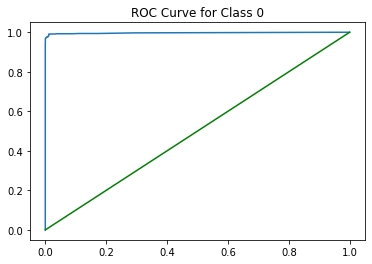

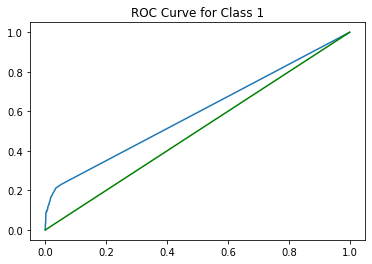

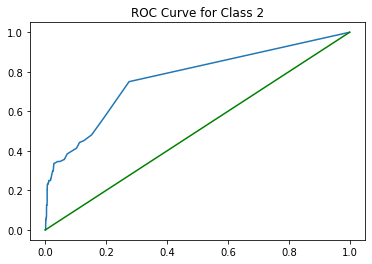

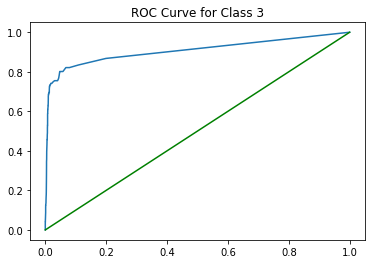

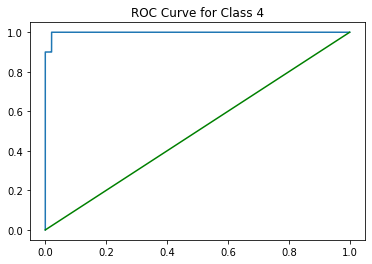

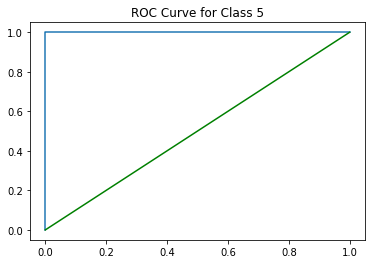

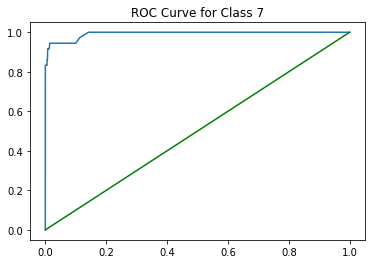

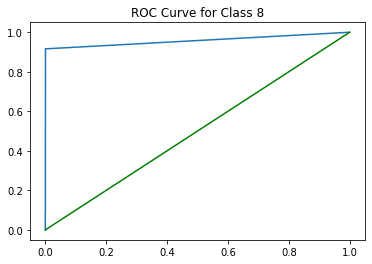

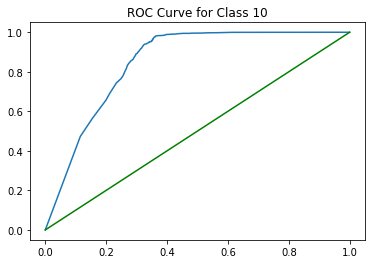

In [ ]:
rocs=h.roc_all(label_df.drop(['label'],axis=1),label_df['label'])

In [ ]:
rocs.to_csv('Model Data/Binary Model/binary_classifier_roc.csv',mode='w')

In [ ]:
test_path=r'Data/Preprocessed/Continuous Wavelet Transformation/Test Set/'
init_test_df=h.dfbuilder(test_path,synth=False,split_df=False,directory=directory,use_trash=False)
print(init_test_df)
test_df=pd.DataFrame(pca.transform(init_test_df.drop(['label'],axis=1).values),index=init_test_df.index.values)
test_df['label']=init_test_df['label']
print(len(test_df.index),",",len(m_list))
labels=np.empty(shape=(len(test_df.index),len(m_list)))
for j in range(len(m_list)):
  labels[:,j]=m_list[j].predict_proba(test_df.drop(['label'],axis=1))[:,1]
label_df=pd.DataFrame(labels,index=test_df.index.values,columns=[0,1,2,3,4,5,7,8,10])
label_df['label']=test_df['label']

#label_df.to_csv('Model Data/Binary Model/binary_classifier_probs.csv',mode='w')

Master data set shape is (5310, 191) 


                                    150       155  ...      1095  label
granite0dust_test_015s_5184-0 -0.049600  0.164744  ...  0.226225      0
granite0dust_test_015s_5184-1 -0.048366  0.119668  ...  0.173724      0
granite0dust_test_015s_5184-2 -0.052654  0.131285  ...  0.188201      0
granite0dust_test_015s_5184-3 -0.051109  0.114049  ...  0.173292      0
granite0dust_test_015s_5184-4 -0.061070  0.313235  ...  0.515929      0
...                                 ...       ...  ...       ...    ...
L_cwt_qtz_rruff_test_5.csv    -0.082538 -0.122935  ...  0.001077      0
L_cwt_qtz_rruff_test_6.csv    -0.044578 -0.060850  ... -0.000771      0
L_cwt_qtz_rruff_test_7.csv    -0.043728 -0.059529  ... -0.001519      0
L_cwt_qtz_rruff_test_8.csv    -0.042953 -0.058225  ... -0.000331      0
L_cwt_qtz_rruff_test_9.csv    -0.046770 -0.063467  ...  0.003103      0

[5310 rows x 191 columns]
5310 , 9


In [ ]:
print(label_df)

                                  0    1     2     3  ...     7    8    10  label
granite0dust_test_015s_5184-0  1.00  0.0  0.02  0.02  ...  0.04  0.0  0.18      0
granite0dust_test_015s_5184-1  1.00  0.0  0.01  0.00  ...  0.03  0.0  0.00      0
granite0dust_test_015s_5184-2  1.00  0.0  0.06  0.01  ...  0.04  0.0  0.01      0
granite0dust_test_015s_5184-3  1.00  0.0  0.01  0.00  ...  0.04  0.0  0.00      0
granite0dust_test_015s_5184-4  1.00  0.0  0.00  0.00  ...  0.00  0.0  0.00      0
...                             ...  ...   ...   ...  ...   ...  ...   ...    ...
L_cwt_qtz_rruff_test_5.csv     0.98  0.0  0.00  0.00  ...  0.00  0.0  0.00      0
L_cwt_qtz_rruff_test_6.csv     0.97  0.0  0.01  0.00  ...  0.02  0.0  0.00      0
L_cwt_qtz_rruff_test_7.csv     0.97  0.0  0.01  0.00  ...  0.00  0.0  0.00      0
L_cwt_qtz_rruff_test_8.csv     0.97  0.0  0.01  0.00  ...  0.02  0.0  0.00      0
L_cwt_qtz_rruff_test_9.csv     0.97  0.0  0.01  0.00  ...  0.01  0.0  0.00      0

[5310 rows x 10

In [ ]:
predicted=h.dec_pred(label_df.drop(['label'],axis=1).values,0.0)
print(predicted)

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(label_df['label'],predicted)
print(cm)
output_probs=pd.DataFrame(predicted,index=label_df.index.values)
output_probs['label']=label_df['label']
output_probs.to_csv('Model Data/Binary Model/predictions_no_thresh.csv',mode='w')
pd.DataFrame(cm).to_csv('Model Data/Binary Model/confmat_no_thresh.csv',mode='w')

[[1571    0   12    0    1    0    0    0    3    0]
 [   6   99    2    2    0    0    0    0 1111    0]
 [   9    0   27   58    1    0    0    0    9    0]
 [  14    0   20  107    1    0    0    0    9    0]
 [   0    0    0    0   20    0    0    0    0    0]
 [   0    0    0    0    0   35    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [  29    0    5    0    0    0    2    0    0    0]
 [   3    0    9    0    0    0    0    0    0    0]
 [   8   10    6    1   28    6    0    0 2086    0]]


In [ ]:
from sklearn.metrics import f1_score

actual=label_df['label']
print(f1_score(actual, predicted, average="weighted"))

0.35821426538981055
